## 2. Surrogate model


Model predictions are explained by learning a second, usually more explainable model, as a proxy: this is explaining the decisions of the first model through a second. Surrogate model-based approaches are model-agnostic and can be used to achieve either local or global explanations.

The most well-known example for this technique is [LIME](https://github.com/marcotcr/lime), the library behind the paper [Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938) , which learns surrogate models using an operation called input perturbation.

In their documentation, they provide a way to test it with Random Forests. Our contribution is to provide as well, the code for using the LIME explanator with neural networks, concretely with our own finetuned model that we have used in the rest of techniques.

## Experiments - LIME with Random Forest

In [138]:
import sklearn
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from src.preprocess import get_train_dev_test_data

In [143]:
train, _, test = get_train_dev_test_data()
class_names = ["negative", "positive", "neutral", "mixed"]

In [140]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(train["verse_text"])
test_vectors = vectorizer.transform(test["verse_text"])

In [141]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, train["labels"])

RandomForestClassifier(n_estimators=500)

In [142]:
c = make_pipeline(vectorizer, rf)

In [144]:
explainer = LimeTextExplainer(class_names=class_names)

In [151]:
sample = test["verse_text"][93]

In [152]:
sample

'From when your Brooklyn broke my skin and bones'

In [146]:
exp = explainer.explain_instance(sample, c.predict_proba, num_features=6)

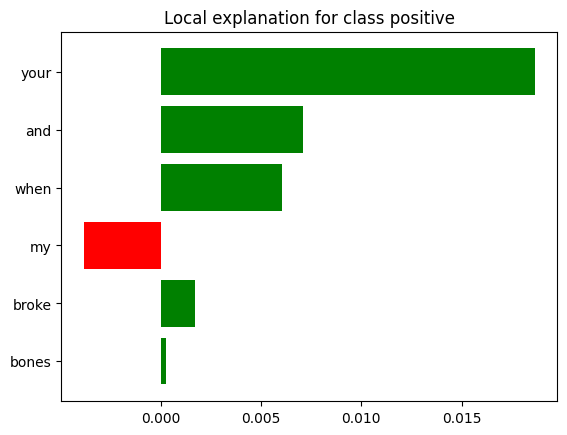

In [147]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [153]:
%matplotlib inline
exp.show_in_notebook(text=True)

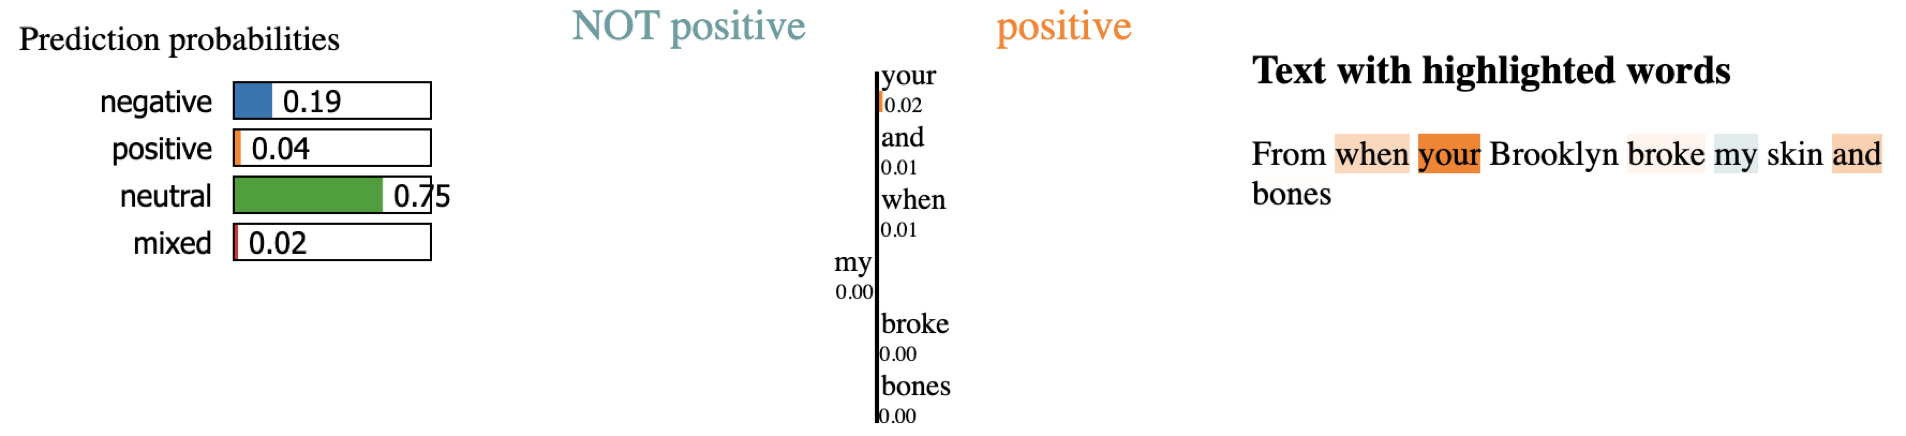

## Experiments - LIME with Neural Networks

In [47]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from src.preprocess import get_train_dev_test_data
from transformers import TextClassificationPipeline
from lime.lime_text import LimeTextExplainer
import numpy as np

In [4]:
_, _, test = get_train_dev_test_data()

In [7]:
class_names = ["negative", "positive", "neutral", "mixed"]

In [12]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained(
    "pretrained_model/", num_labels=4
)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)

Let's create a function that adapts predicts the probabilities for each class and returns it in a numpy array of with as many rows as input samples and as many columns as labels (in our case 4). The i,j position of this matrix will be the score (logits) of class j for sample i.
A function with these characteristics is also what the LIME model expects:

In [48]:
def predict_all_probs(samples):
    predictions = pipe(samples, top_k=4)
    scores = []

    for prediction in predictions:
        sorted_by_class_predictions = sorted(prediction, key=lambda x: x["label"])
        only_scores = [pred["score"] for pred in sorted_by_class_predictions]
        scores.append(only_scores)
    return np.array(scores)

In [49]:
explainer = LimeTextExplainer(class_names=class_names)

In [131]:
sample = test["verse_text"][93]

In [132]:
sample

'From when your Brooklyn broke my skin and bones'

In [133]:
# this cell takes a bit to execute !
exp_brooklyn = explainer.explain_instance(
    sample, predict_all_probs, num_features=len(sample.split(" ")), top_labels=4
)

In [134]:
print(exp_brooklyn.available_labels())

[0, 3, 2, 1]


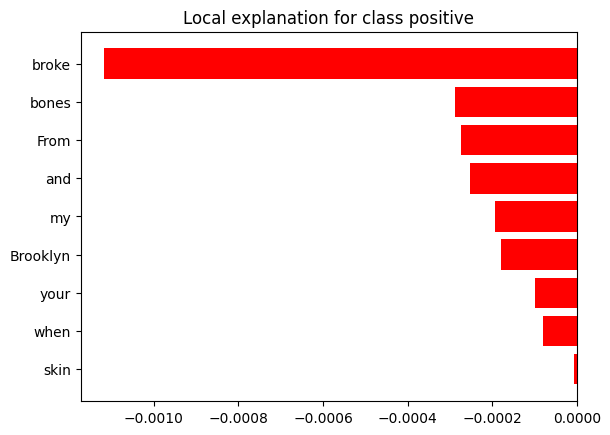

In [135]:
%matplotlib inline
fig = exp_brooklyn.as_pyplot_figure()

In [150]:
%matplotlib inline
exp_brooklyn.show_in_notebook()

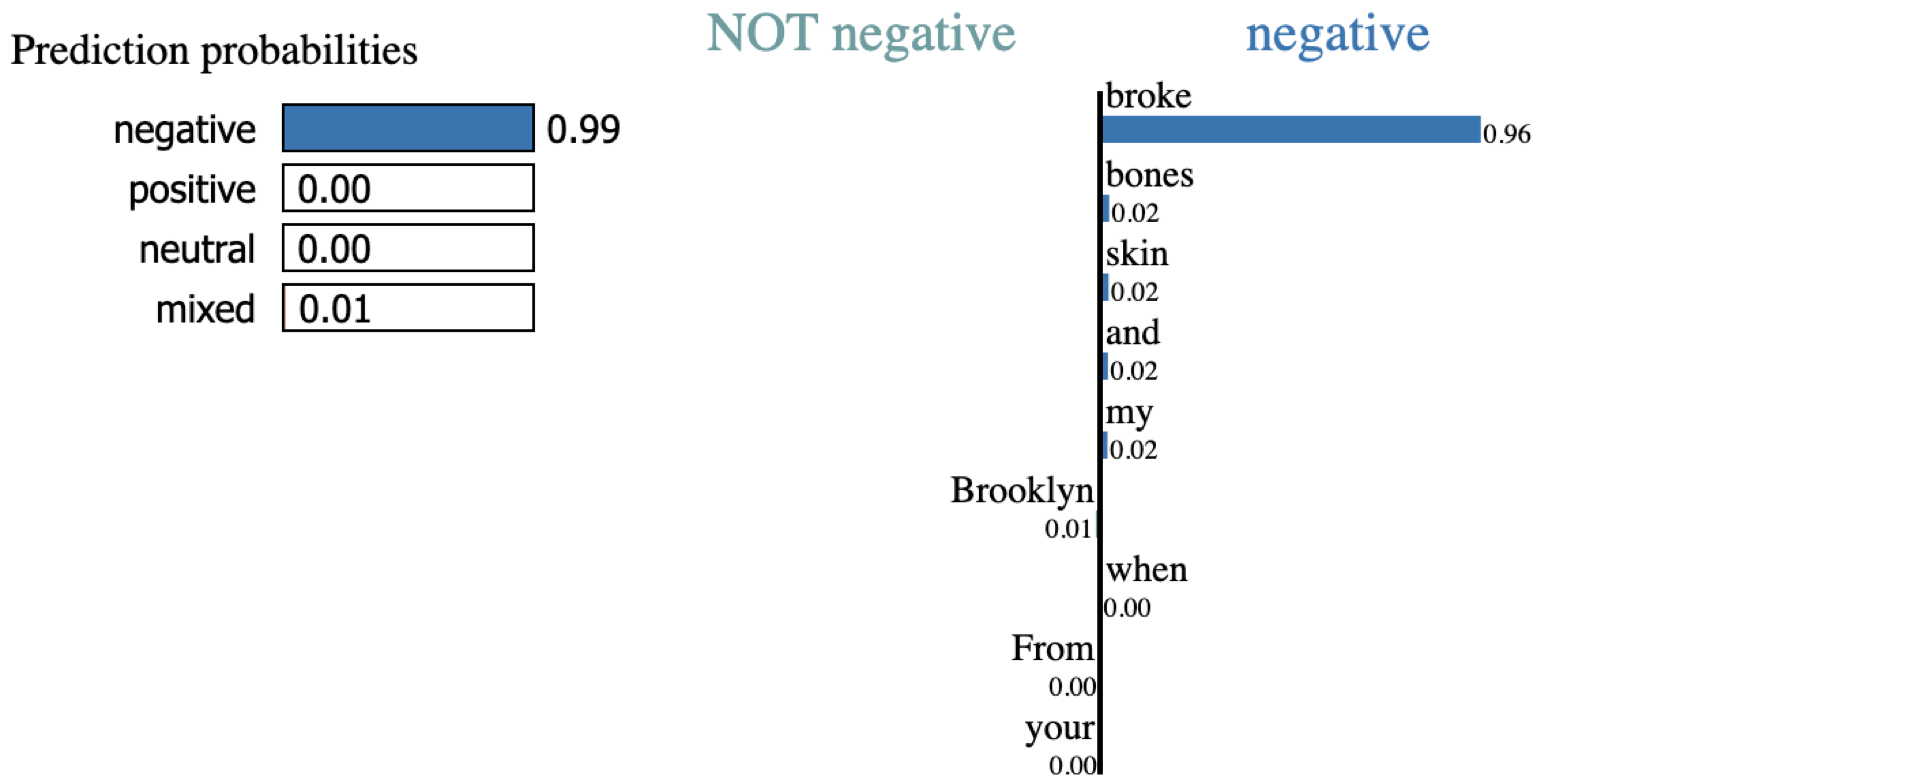

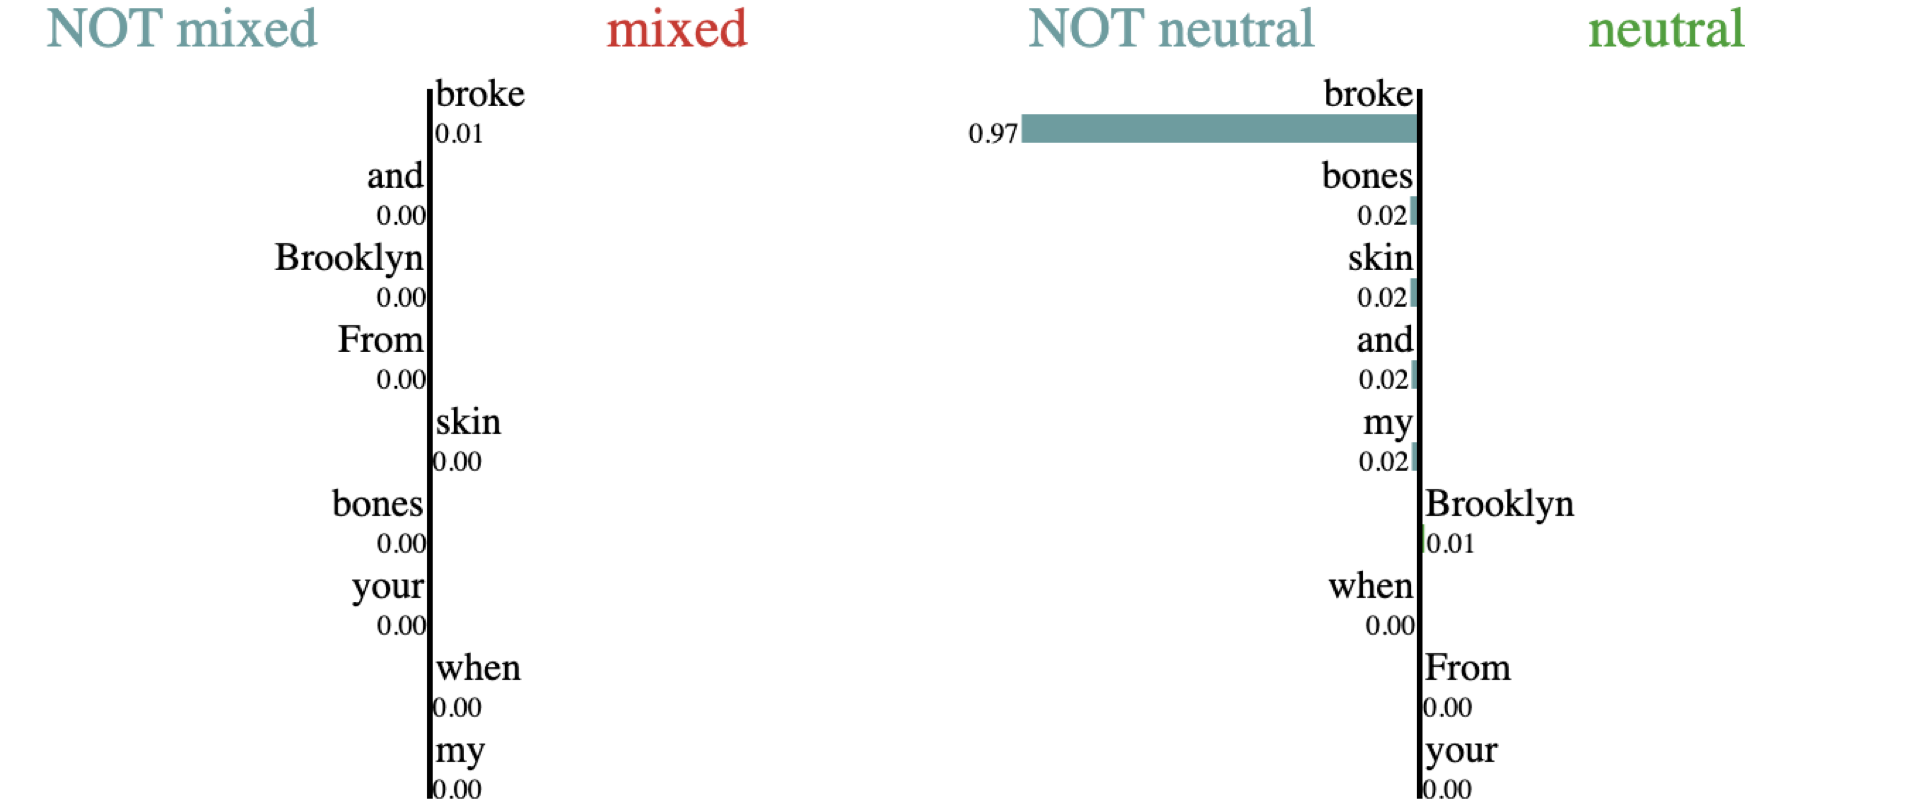

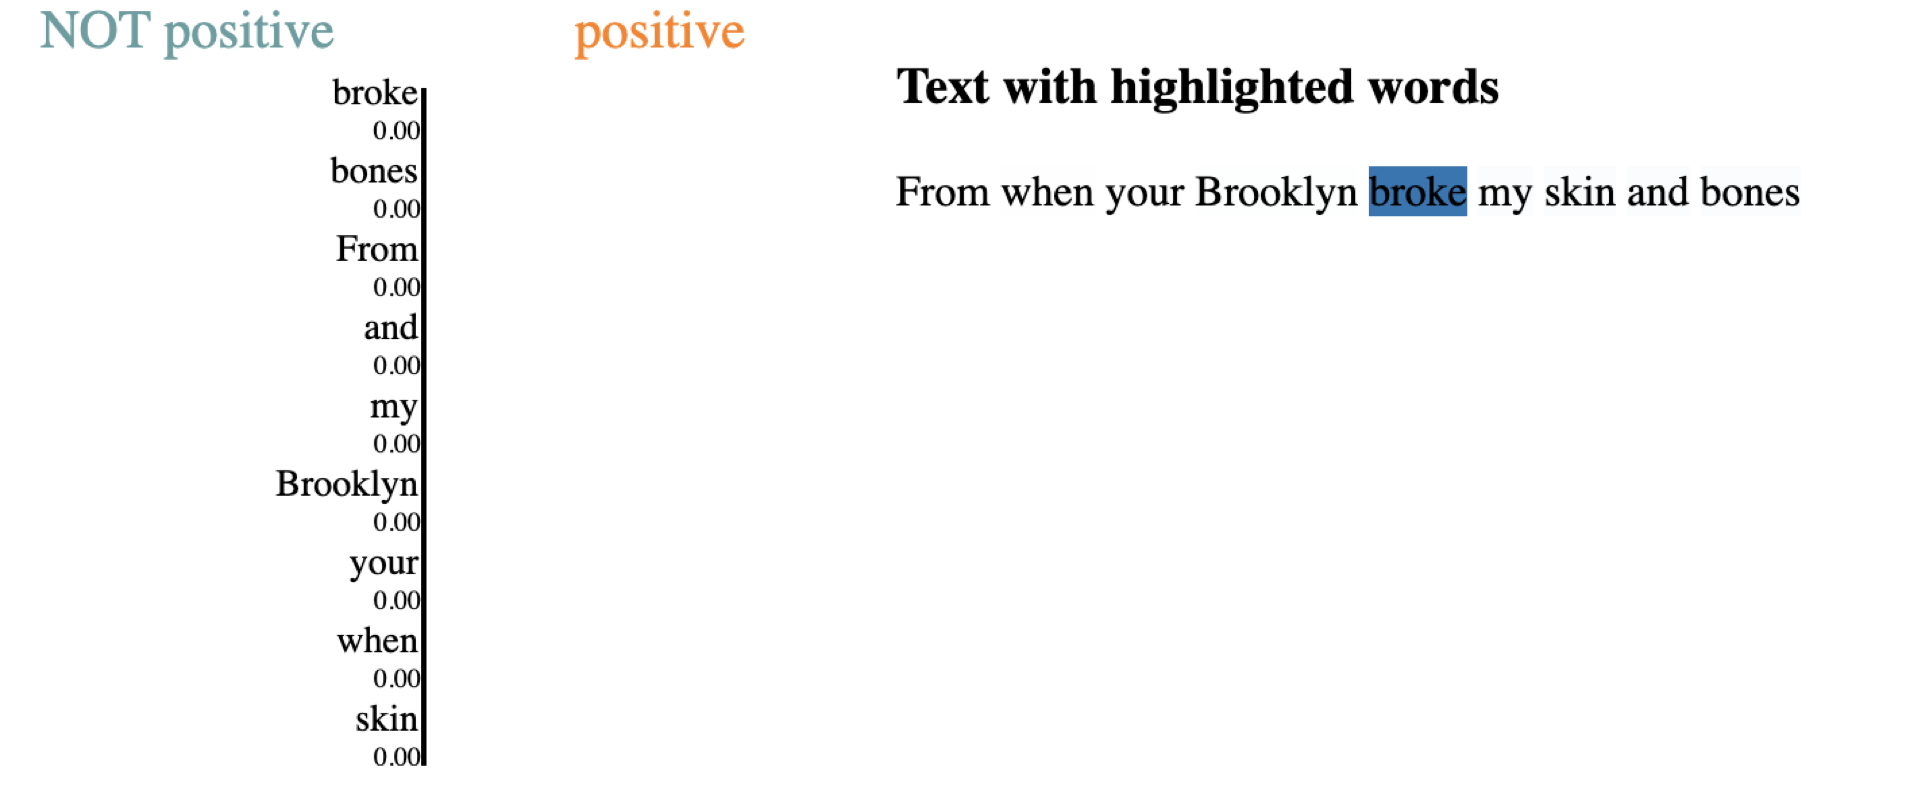

## Conclusions

* Learned surrogate models and the original models may have completely different mechanisms to make predictions, leading to concerns about the fidelity of surrogate model-based approaches.

* Specifically LIME:
    * It is restricted to classification algorithms so this limits many other models: regression models, generative models, etc.
    * The explainer takes long to generate the explanations for one single sample (3min of execution just one sample) when using our neural model.